In [1]:
#Install the datasets library
!pip install datasets
!pip install sentencepiece
!pip install transformers datasets
!pip install transformers[torch]
!pip install accelerate
!pip install accelerate>=0.20.1
!pip install huggingface_hub
!pip3 install -q transformers datasets

In [2]:
import os
import pandas as pd
import numpy as np
import plotly
import string
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.model_selection import train_test_split

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig, AdamW
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import mean_squared_error
from huggingface_hub import notebook_login

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import string
import tensorflow as tf

# add datasets
data = pd.read_csv("/kaggle/input/finetuning-llm/Dataset_Finetuning.csv")

# convert labels to numeric values
data['output'] = data['output'].apply(lambda s: 0 if s == 'NO' else 1)
data

,instruction,input,output
0,Categorize the essay into two categories as to...,California is the biggest example of city plan...,1
1,Categorize the essay into two categories as to...,A life without cars sure sounds like a great i...,0
2,Categorize the essay into two categories as to...,Cars are used used in everyday life but they m...,0
3,Categorize the essay into two categories as to...,The electoral collage should be disbanded. Not...,0
4,Categorize the essay into two categories as to...,"Dear Mr.Mrs. Senator, The Electoral College is...",0
...,...,...,...
2489,Categorize the essay into two categories as to...,"Dear Florida senator, It is in the interest of...",0
2490,Categorize the essay into two categories as to...,Driving can be a huge hassle. Having to spend ...,0
2491,Categorize the essay into two categories as to...,"Dear\nSenator,\n\nI am writing to express my o...",1
2492,Categorize the essay into two categories as to...,"The electoral college is pointless, I believe ...",0


In [4]:
# Remove punctuation and lowercase data
data['input'] = data['input'].apply(lambda s: s.translate(str.maketrans('', '', string.punctuation)))
data['input'] = data['input'].apply(lambda s: s.lower())

# Remove all non alphanumeric char
data["input"] = data["input"].apply(lambda s: re.sub(r'[^\w\s]', '', s))
data

,instruction,input,output
0,Categorize the essay into two categories as to...,california is the biggest example of city plan...,1
1,Categorize the essay into two categories as to...,a life without cars sure sounds like a great i...,0
2,Categorize the essay into two categories as to...,cars are used used in everyday life but they m...,0
3,Categorize the essay into two categories as to...,the electoral collage should be disbanded not ...,0
4,Categorize the essay into two categories as to...,dear mrmrs senator the electoral college is a ...,0
...,...,...,...
2489,Categorize the essay into two categories as to...,dear florida senator it is in the interest of ...,0
2490,Categorize the essay into two categories as to...,driving can be a huge hassle having to spend m...,0
2491,Categorize the essay into two categories as to...,dear\nsenator\n\ni am writing to express my op...,1
2492,Categorize the essay into two categories as to...,the electoral college is pointless i believe t...,0


In [5]:
train, test = train_test_split(data, test_size=0.1, random_state=42, stratify=data['output'])
train, valid = train_test_split(train, test_size=0.1, random_state=42, stratify=train['output'])

In [6]:
train

,instruction,input,output
1952,Categorize the essay into two categories as to...,cars cars have been around since they became f...,0
190,Categorize the essay into two categories as to...,it is no secret that he hoverheads rule the ci...,1
704,Categorize the essay into two categories as to...,boom the sound of ginormous truck slamming int...,0
1988,Categorize the essay into two categories as to...,the electoral college is a bad thing because v...,0
1810,Categorize the essay into two categories as to...,election by popular vote would be a much bette...,0
...,...,...,...
655,Categorize the essay into two categories as to...,cars though useful have negative impacts on th...,0
1035,Categorize the essay into two categories as to...,dear state senator the electoral college shoul...,0
2487,Categorize the essay into two categories as to...,the electoral college is a system which was es...,0
510,Categorize the essay into two categories as to...,dear senator\n\ni believe that the electoral c...,1


In [7]:
valid

,instruction,input,output
996,Categorize the essay into two categories as to...,there was a time when cars were a new inventio...,0
447,Categorize the essay into two categories as to...,dear florida senator i cant help but notice th...,0
727,Categorize the essay into two categories as to...,limiting car usage is a vital aspect that can ...,1
1030,Categorize the essay into two categories as to...,dear senator\n\ni am writing today to argue in...,1
1515,Categorize the essay into two categories as to...,in 2000 when al gore got more individual votes...,0
...,...,...,...
1873,Categorize the essay into two categories as to...,limiting the usage of cars has personal and pr...,0
990,Categorize the essay into two categories as to...,when the dangers of relying on cars has become...,1
318,Categorize the essay into two categories as to...,dear state senator it is highly unlikely that ...,0
1933,Categorize the essay into two categories as to...,dear florida state senator it has been brought...,0


In [8]:
test

,instruction,input,output
182,Categorize the essay into two categories as to...,over the past years massive car usage has incr...,0
1576,Categorize the essay into two categories as to...,the election system should be changed to popul...,0
1020,Categorize the essay into two categories as to...,the laws have changed we now have days where w...,0
701,Categorize the essay into two categories as to...,the electoral college is not a fair system for...,0
1779,Categorize the essay into two categories as to...,the electoral college vote draws many emotions...,0
...,...,...,...
41,Categorize the essay into two categories as to...,many people throughout the world would agree t...,0
1527,Categorize the essay into two categories as to...,dear for proper the not drink in in the at was...,1
221,Categorize the essay into two categories as to...,fellow citizenis i would like to talk about th...,0
893,Categorize the essay into two categories as to...,dear senator i know you have a lot of things o...,0


In [9]:
train.to_csv("/kaggle/working/train_subset.csv", index=False)
valid.to_csv("/kaggle/working/eval_subset.csv", index=False)

In [10]:
train

,instruction,input,output
1952,Categorize the essay into two categories as to...,cars cars have been around since they became f...,0
190,Categorize the essay into two categories as to...,it is no secret that he hoverheads rule the ci...,1
704,Categorize the essay into two categories as to...,boom the sound of ginormous truck slamming int...,0
1988,Categorize the essay into two categories as to...,the electoral college is a bad thing because v...,0
1810,Categorize the essay into two categories as to...,election by popular vote would be a much bette...,0
...,...,...,...
655,Categorize the essay into two categories as to...,cars though useful have negative impacts on th...,0
1035,Categorize the essay into two categories as to...,dear state senator the electoral college shoul...,0
2487,Categorize the essay into two categories as to...,the electoral college is a system which was es...,0
510,Categorize the essay into two categories as to...,dear senator\n\ni believe that the electoral c...,1


In [11]:
from datasets import Dataset, DatasetDict

train_data = Dataset.from_pandas(train, preserve_index=False)
valid_data = Dataset.from_pandas(valid, preserve_index=False)

In [12]:
train_data

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 2019
})

In [13]:
valid_data

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 225
})

In [14]:
dataset = DatasetDict()
dataset['train'] = train_data
dataset['eval'] = valid_data

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 2019
    })
    eval: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 225
    })
})

In [16]:
# Import the tokenizer from transformers library
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('openai-community/roberta-base-openai-detector')

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [17]:
# Function to transform labels
def transform_labels(label):
    label = label['output']
    num = 0
    if label == 0: 
        num = 0
    elif label == 1: 
        num = 1
    return {'labels': num}

# Function to tokenize data
def tokenize_data(example):
    return tokenizer(example['input'], padding=True, truncation=True, max_length=512)

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['input', 'output', 'instruction']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)
dataset

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2019 [00:00<?, ?ex/s]

  0%|          | 0/225 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2019
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 225
    })
})

In [18]:
from transformers import TrainingArguments
import transformers

# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
# Training Arguments
training_args = TrainingArguments(
    output_dir="/kaggle/working/my_trainer_roberta-base-openai-detector",
    num_train_epochs=5,
    load_best_model_at_end=True,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
)


In [19]:
from transformers import AutoModelForSequenceClassification

# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("openai-community/roberta-base-openai-detector", num_labels=2)

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at openai-community/roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
train_dataset = dataset['train'].shuffle(seed=25)
eval_dataset = dataset['eval'].shuffle(seed=25)

In [21]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"rmse": mean_squared_error(labels, predictions, squared=False)}

In [22]:
# Model Training Setup
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [23]:
import wandb
wandb.login(key='6c6c7d7b9ab08d6b2b2b4c43dbff0d58fa56a577')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
# Launch the learning process: training
trainer.train()

wandb: Currently logged in as: gyandeepkalita1 (nitsilchar). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240128_152321-mp0dnfeq
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run gallant-bee-10
wandb: ⭐️ View project at https://wandb.ai/nitsilchar/huggingface
wandb: 🚀 View run at https://wandb.ai/nitsilchar/huggingface/runs/mp0dnfeq
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rmse
1,0.381100,0.437474,0.359011
2,0.091100,0.077000,0.149071
3,0.032600,0.062785,0.115470
4,0.003800,0.003710,0.000000
5,0.001600,0.009190,0.066667


TrainOutput(global_step=635, training_loss=0.10202891418314355, metrics={'train_runtime': 609.718, 'train_samples_per_second': 16.557, 'train_steps_per_second': 1.041, 'total_flos': 2656106103859200.0, 'train_loss': 0.10202891418314355, 'epoch': 5.0})

In [25]:
trainer.save_model('/kaggle/working/Finetuned_Roberta_Openai')

In [26]:
test_dataset = Dataset.from_pandas(test, preserve_index=False)
test_dataset

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 250
})

In [27]:
test_df = DatasetDict()
test_df['train'] = test_dataset

test_df

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 250
    })
})

In [28]:
test_df = test_df.map(tokenize_data, batched=True)
test_df

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'input_ids', 'attention_mask'],
        num_rows: 250
    })
})

In [29]:
model_Roberta = AutoModelForSequenceClassification.from_pretrained('/kaggle/working/Finetuned_Roberta_Openai')

In [30]:
test = test.reset_index(drop=True)
test

,instruction,input,output
0,Categorize the essay into two categories as to...,over the past years massive car usage has incr...,0
1,Categorize the essay into two categories as to...,the election system should be changed to popul...,0
2,Categorize the essay into two categories as to...,the laws have changed we now have days where w...,0
3,Categorize the essay into two categories as to...,the electoral college is not a fair system for...,0
4,Categorize the essay into two categories as to...,the electoral college vote draws many emotions...,0
...,...,...,...
245,Categorize the essay into two categories as to...,many people throughout the world would agree t...,0
246,Categorize the essay into two categories as to...,dear for proper the not drink in in the at was...,1
247,Categorize the essay into two categories as to...,fellow citizenis i would like to talk about th...,0
248,Categorize the essay into two categories as to...,dear senator i know you have a lot of things o...,0


In [31]:
test_inputs = [x for x in test['input']]
test_inputs

['over the past years massive car usage has increased bringing multiple detergents today fellow citizens should realize the harm to the world brought by growing car usage the advantages of limiting car usage is a benefit promoting communities thatare less dependent on carsand can be a improvement in air pollution consequences the advantages to begin limiting car usage can have many beneficial effects in the worldwide\n\ninnitialy  the advantages of limiting car usage is a benefit due to the fact that communities will be less dependent on cars in source 3 paragraph 28 the author explains an example of a benefit of limited car usage stating uneven pitted side walks have been replaced by broad smooth sidewalks rush hour restrictions have dramatically cut traffic and new restaurants and upscale shopping districts have croped up this shows how human beings are using cars less by walking increasing some health issues creating less traffic accidents and increasing the economy by shopping with

In [32]:
import torch

predictions = []
for text in test_inputs:
    inputs = tokenizer(text,padding = True, truncation = True, max_length=512, return_tensors='pt')
    outputs = model_Roberta(**inputs)
    prediction = torch.nn.functional.softmax(outputs.logits, dim=-1)[:, 1].item()
    predictions.append(prediction)
    
predictions

[0.00025194542831741273,
 0.00010804616613313556,
 0.00010306819604011253,
 0.0001028499536914751,
 0.0005785114481113851,
 0.00010806088539538905,
 0.00010291254875482991,
 0.9998778104782104,
 0.00010333785030525178,
 0.00010295572428731248,
 0.00010412829578854144,
 0.00010605432180454955,
 0.9998747110366821,
 0.9998795986175537,
 0.00020413286983966827,
 0.9998767375946045,
 0.9996386766433716,
 0.9998809099197388,
 0.00010310310608474538,
 0.00011607463238760829,
 0.00010638360254233703,
 0.0001022984943119809,
 0.9998764991760254,
 0.00010208936873823404,
 0.9998892545700073,
 0.999901294708252,
 0.9998836517333984,
 0.9998877048492432,
 0.9998883008956909,
 0.9998682737350464,
 0.9998823404312134,
 0.00010403083433629945,
 0.00011662360338959843,
 0.9998795986175537,
 0.00010376729187555611,
 0.00010384906636318192,
 0.9531059861183167,
 0.00010331991506973282,
 0.00010380767344031483,
 0.9998689889907837,
 0.0001571566826896742,
 0.0001026133686536923,
 0.000102448437246494,
 

In [33]:
test_labels = [x for x in test['output']]
test_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0]

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       138
           1       0.96      0.99      0.97       112

    accuracy                           0.98       250
   macro avg       0.97      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



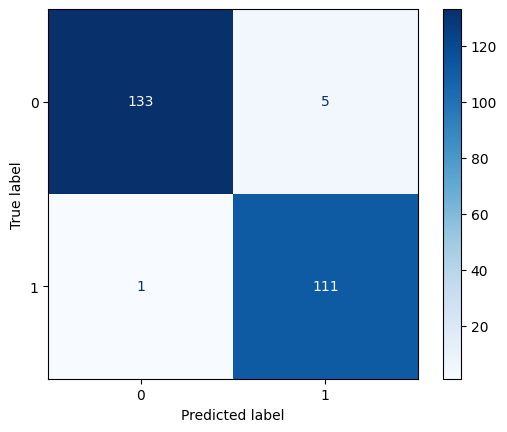

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Convert predicted probabilities to binary predictions (0 or 1) based on a threshold
threshold = 0.5  # Adjust the threshold as needed
binary_predictions = [1 if prob >= threshold else 0 for prob in predictions]

# Compute the confusion matrix
cm = confusion_matrix(test_labels, binary_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues', values_format='d')

# Generate a classification report
report = classification_report(test_labels, binary_predictions, target_names=['0', '1'])

# Print the classification report
print(report)

In [35]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.976
